In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import Subset
import pandas as pd
import math
from dataclasses import dataclass

# Dataset and Dataloader creation

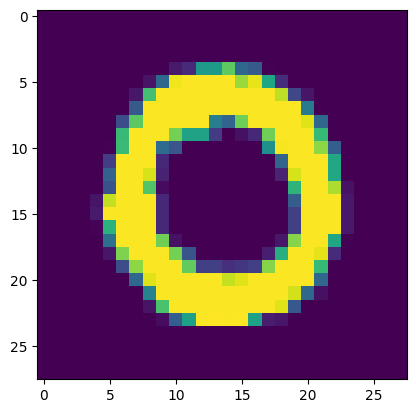

In [39]:
data = pd.read_csv('train.csv')
import matplotlib.pyplot as plt
plt.imshow(data.iloc[1].values[1:].reshape((28,28)))

In [14]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.stop_token = 256 + 10 # 256 - 265 correspond to labels, which we can condition on
    
    def __getitem__(self, idx):
        label_token = self.data.iloc[idx].values[0] + 256
        data = torch.tensor([label_token] + list(self.data.iloc[idx].values)[1:] + [self.stop_token], dtype=torch.long)
        
        inputs = data[:-1]
        labels = data[1:]
        
        return inputs, labels
    
    
    def __len__(self):
        return len(self.data)

In [15]:
# taking the dataset for a spin
sample_dataset = MNISTDataset("train.csv", )
x,y = next(iter(sample_dataset))
print(x.shape)
print(y.shape)

torch.Size([785])
torch.Size([785])


In [16]:
# split dataset into train and validation
validation_fraction = 0.1
batch_size = 64


whole_dataset = MNISTDataset("train.csv")
split_idx = int(len(whole_dataset)*validation_fraction)

val_indices = [i for i in range(0,split_idx)]
train_indices = [i for i in range(split_idx, len(whole_dataset))]

val_set = Subset(whole_dataset, val_indices)
train_set = Subset(whole_dataset, train_indices)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [17]:
x, y = next(iter(train_loader))

In [18]:
x.shape, y.shape

(torch.Size([64, 785]), torch.Size([64, 785]))

# GPT!!!

In [19]:
# class NewGELU(nn.Module):
#     def forward(self,x):
#         return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

In [20]:
class GPTConfig:
    block_size: int = 786
    vocab_size: int = 320
    n_layer: int = 8   # Reduced number of layers
    n_head: int = 8    # Reduced number of heads
    n_embd: int = 320  # Reduced embedding size
    dropout: float = 0.1
    bias: bool = True

In [21]:
class LayerNorm(nn.Module):
    
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
        
    def forward(self,x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

In [22]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # key, query, value projection
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        
        # self.dropout = nn.Dropout(config.dropout)
        
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1,1,config.block_size, config.block_size))

        
    def forward(self, x):
        B, T, C = x.size() # (B, T, C)
        
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)  # (B, T, 3C) --> (B, T, C) (x 3)
        
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_h, T, h_dim)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1,2) # (B, n_h, T, h_dim)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1,2) # (B, n_h, T, h_dim)
        
        att_scores = (q @ k.transpose(-1, -2)) * (1.0 / math.sqrt(k.size(-1))) # (B, n_h, T, T)
        att_scores = att_scores.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf')) 
        
        # print(att_scores.shape)
        att_scores = F.softmax(att_scores, dim=-1) # (B, n_h, T, T)
        # print(att_scores)
        
        
        att_scores = self.attn_dropout(att_scores)
        
        out = att_scores @ v # (B, n_h, T, h_dim)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        
        out = self.resid_dropout(self.c_proj(out))
        
        return out
        

In [23]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4*config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4*config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [24]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)
        
        
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [25]:
class GPT(nn.Module):
    
    def __init__(self, config):
        
        super().__init__()
        
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, config.bias)  
        ))
        
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.lm_head.weight = self.transformer.wte.weight
        
        # init all weights
        self.apply(self._init_weights)
        
        
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2* config.n_layer))
        print(f"number of parameters: {self.get_num_params()/1e6:.4f}")
        
        
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
                
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
        
        
    
    def get_num_params(self, non_embedding=True):
        total_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params = total_params - self.transformer.wpe.weight.numel()
        return n_params
        
        
    
    def forward(self, idx, targets=None):
        # targets: (B, T)
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, device=device, dtype=torch.long)
        
        # forward the GPT model
        tok_emb = self.transformer.wte(idx) # (B,T) --> (B, T, C)
        pos_emb = self.transformer.wpe(pos) # (T) --> (1, T, C)
        
        x = self.transformer.drop(tok_emb + pos_emb)
        
        for block in self.transformer.h:
            x = block(x)
            
        x = self.transformer.ln_f(x)
        
        
        if targets is not None:
            logits = self.lm_head(x) # (B, T, vocab_size)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
            
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None
    
    
    @torch.no_grad()
    def generate(self, idx, temperature=1.0, do_sample=False, top_k=None):
        
        while idx.size(1) < self.config.block_size:
            
            print(idx.size(1))
            # print(idx.shape)
            logits, _ = self(idx)
            # print(logits.shape)
            
            logits = logits[:, -1, :] / temperature
            
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
                
            # print(logits.shape)
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            
            # print(probs.shape)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
            
        
        return idx           

# training loop

In [52]:
model = GPT(GPTConfig())

number of parameters: 9.9667


In [26]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR

In [31]:
learning_rate = 5e-7
num_epochs = 5

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)

print_every = 50

In [32]:
def train_epoch(model, loader, optimizer, epoch_num, device, log_every=50):
    model.train()
    total_loss = 0

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits, loss = model(x, y)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if i % log_every == 0:
            print(f"Epoch: {epoch_num}, Iteration: {i}, Loss: {loss.item():.4f}")

    return total_loss / len(loader)


def validation_epoch(model, loader, epoch_idx, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)

            logits, loss = model(x, y)
            total_loss += loss.item()

    val_loss = total_loss / len(loader)
    print(f"Epoch {epoch_idx}, Validation Loss: {val_loss:.4f}")
    return val_loss


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

for i in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, i, device)
    val_loss = validation_epoch(model, val_loader, i, device)
    scheduler.step()

    print(f"Epoch {i} Summary: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch: 0, Iteration: 0, Loss: 0.5171
Epoch: 0, Iteration: 50, Loss: 0.5608
Epoch: 0, Iteration: 100, Loss: 0.5881
Epoch: 0, Iteration: 150, Loss: 0.5272
Epoch: 0, Iteration: 200, Loss: 0.5006
Epoch: 0, Iteration: 250, Loss: 0.5599
Epoch: 0, Iteration: 300, Loss: 0.5094
Epoch: 0, Iteration: 350, Loss: 0.5248
Epoch: 0, Iteration: 400, Loss: 0.5807
Epoch: 0, Iteration: 450, Loss: 0.5556
Epoch: 0, Iteration: 500, Loss: 0.5109
Epoch: 0, Iteration: 550, Loss: 0.5451
Epoch 0, Validation Loss: 0.5451
Epoch 0 Summary: Train Loss: 0.5435, Validation Loss: 0.5451
Epoch: 1, Iteration: 0, Loss: 0.5774
Epoch: 1, Iteration: 50, Loss: 0.5555
Epoch: 1, Iteration: 100, Loss: 0.4958
Epoch: 1, Iteration: 150, Loss: 0.5867
Epoch: 1, Iteration: 200, Loss: 0.5675
Epoch: 1, Iteration: 250, Loss: 0.5626
Epoch: 1, Iteration: 300, Loss: 0.5321
Epoch: 1, Iteration: 350, Loss: 0.5206
Epoch: 1, Iteration: 400, Loss: 0.5508
Epoch: 1, Iteration: 450, Loss: 0.5589
Epoch: 1, Iteration: 500, Loss: 0.5766
Epoch: 1, Itera

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


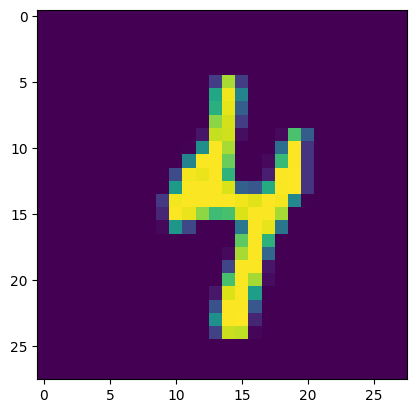

In [65]:
desired_number = 4
idx = torch.tensor([256+desired_number])[None, :].to(device)
output = model.generate(idx)
plt.imshow(output.cpu()[0, 1:-1].contiguous().view(28,28))

In [33]:
torch.save(model.state_dict(), 'trained_model_state_dict.pt')

# evaluation / super cool gif generation

In [18]:
torch.cuda.empty_cache()

# load model and generate

In [9]:
model = GPT(GPTConfig())

state_dict = torch.load('trained_model_state_dict.pt')
model.load_state_dict(state_dict)
model.to('cuda')

number of parameters: 9.9667


/tmp/ipykernel_355848/1944826622.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('trained_model_state_dict.pt')


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(320, 320)
    (wpe): Embedding(786, 320)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=320, out_features=960, bias=True)
          (c_proj): Linear(in_features=320, out_features=320, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=320, out_features=1280, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1280, out_features=320, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=320, out_features=320, bias=False)
)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


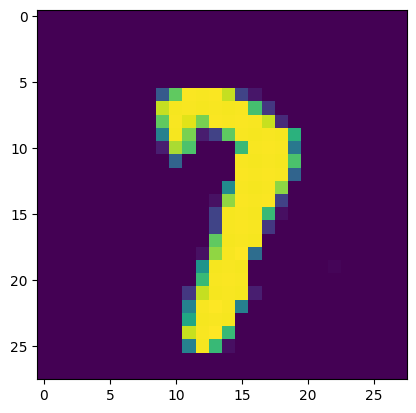

In [83]:
desired_number = 7
idx = torch.tensor([256+desired_number])[None, :].to(device)
output = trained_model.generate(idx)
plt.imshow(output.cpu()[0, 1:-1].contiguous().view(28,28))